Import needed modules

In [1]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

modules loaded


# Create needed functions

## Function to create dataframe
We will use the _create_df()_ function to create train and validation dataframe depending on _define_trpaths()_ and _define_trdf()_ functions which are responsible for getting file paths.

In [2]:
def define_trpaths(train_data, train_csv):
    filepaths = []
    labels = []
    df = pd.read_csv(train_csv)
    files = os.listdir(train_data)
    for file, i in zip(sorted(files), df['diagnosis']):
        fpath = os.path.join(train_data, file)
        filepaths.append(fpath)
        if i == 0:
            labels.append('No DR')
        elif i == 1:
            labels.append('Mild')
        elif i == 2:
            labels.append('Moderate')
        elif i == 3:
            labels.append('Severe')
        elif i == 2:
            labels.append('Proliferative DR')
        else:
            labels.append('Not Classified')
        
    return filepaths, labels

def define_trdf(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(train_data, train_csv):
    # train dataframe
    files, classes = define_trpaths(train_data, train_csv)
    df = define_trdf(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    
    return train_df, valid_df

## Function to generate images from dataframe
_create_gens()_ function is responsible for generating batches of tensor image data with real-time data augmentation.

In [3]:
def create_gens(train_df, valid_df, train_dir):
    img_size = (224, 224)
    channels = 3
    batch_size = 40
    img_shape = (img_size[0], img_size[1], channels)
    
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    val_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', directory = train_dir, target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', directory = train_dir, target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

    return train_gen, valid_gen

## Function to show images
*show_images()* function is responsible for showing images sample from a specific directory after image generator.

In [4]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [27]:
print(labels[0])

NameError: name 'labels' is not defined

## Callback Class
* We will use a custom callback class MyCallback which is responsible for modifying hyperparameters in run-time.

* It will inherit its parameters and hyperparameters from keras.callbacks.Callback.

In [5]:
### Define a class for custom callback
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

## Function to plot history of training
We will use plot_training() function for plotting trainning history items [accuracy and loss] in train data and validation data.

In [6]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


In [29]:
train_data = '/kaggle/input/aptos2019-blindness-detection/train_images'
train_csv = '/kaggle/input/aptos2019-blindness-detection/train.csv'

filepaths = []
labels = []
df = pd.read_csv(train_csv)
files = os.listdir(train_data)
for file, i in zip(sorted(files), df['diagnosis']):
    fpath = os.path.join(train_data, file)
    filepaths.append(fpath)
    if i == 0:
        labels.append('No DR')
    elif i == 1:
        labels.append('Mild')
    elif i == 2:
        labels.append('Moderate')
    elif i == 3:
        labels.append('Severe')
    elif i == 2:
        labels.append('Proliferative DR')
    else:
        labels.append('Not Classified')

In [30]:
print(labels)

['Moderate', 'Not Classified', 'Mild', 'No DR', 'No DR', 'Not Classified', 'No DR', 'Moderate', 'Moderate', 'Mild', 'No DR', 'Moderate', 'No DR', 'Severe', 'Mild', 'No DR', 'Moderate', 'No DR', 'No DR', 'Moderate', 'Moderate', 'No DR', 'Mild', 'Moderate', 'No DR', 'Moderate', 'No DR', 'No DR', 'No DR', 'No DR', 'No DR', 'No DR', 'Not Classified', 'Moderate', 'Not Classified', 'Moderate', 'No DR', 'No DR', 'Not Classified', 'No DR', 'Not Classified', 'Moderate', 'Moderate', 'Not Classified', 'Moderate', 'Mild', 'Moderate', 'Not Classified', 'No DR', 'Severe', 'Mild', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'No DR', 'Severe', 'No DR', 'Moderate', 'Mild', 'No DR', 'Moderate', 'No DR', 'No DR', 'No DR', 'No DR', 'Moderate', 'Moderate', 'No DR', 'No DR', 'No DR', 'Mild', 'Mild', 'No DR', 'Severe', 'No DR', 'Moderate', 'No DR', 'Moderate', 'No DR', 'Mild', 'Severe', 'Mild', 'No DR', 'Moderate', 'No DR', 'No DR', 'Severe', 'Not Classified', 'Moderate', 'Moderate', 'No DR', 'No DR', 'N

In [32]:
train_df, valid_df = create_df(train_data, train_csv)

# Get Generators
train_gen, valid_gen = create_gens(train_df, valid_df, train_data)
g_dict = train_gen.class_indices
classes = list(g_dict.keys())

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [34]:
print(classes[1])

Moderate


# Model Structure

### Show images sample

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


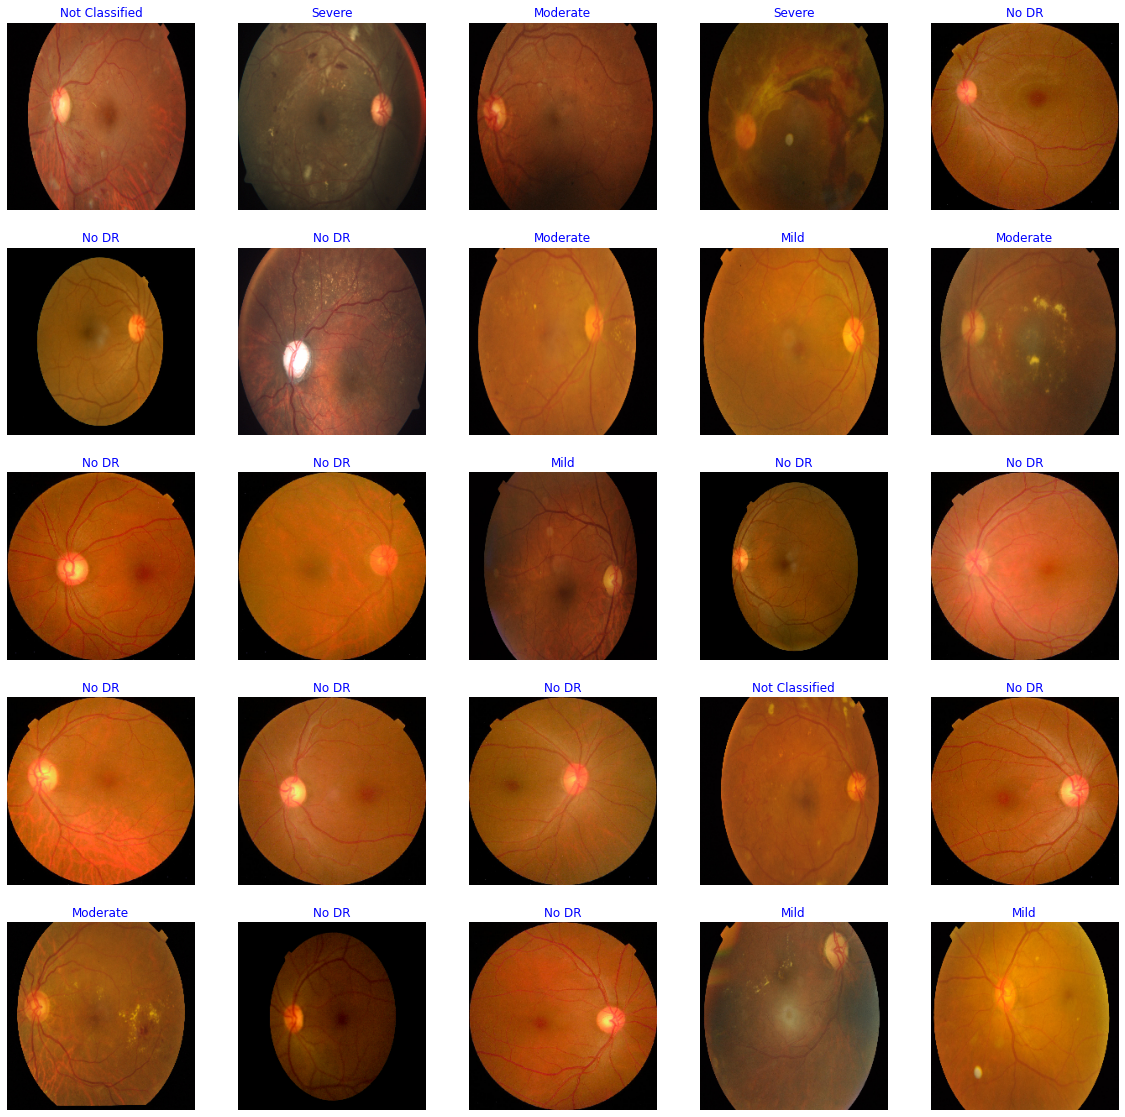

In [7]:
# Get Dataframes
train_data = '/kaggle/input/aptos2019-blindness-detection/train_images'
train_csv = '/kaggle/input/aptos2019-blindness-detection/train.csv'

train_df, valid_df = create_df(train_data, train_csv)

# Get Generators
train_gen, valid_gen = create_gens(train_df, valid_df, train_data)

show_images(train_gen)

In [25]:
#print(class_name)

NameError: name 'class_name' is not defined

### Create Pre-trained model
We will use _EfficientNetB5

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

115277824/115263384 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 29,047,548
Trainable params: 28,870,709
Non-trainable params: 176,839
_________________________________________________________________


### Get custom callbacks parameters

In [9]:
batch_size = 40
epochs = 40
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

### Train model

In [10]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     8.220   66.371   9.42766  54.707   0.00100  0.00100  accuracy     0.00    532.62 
 2 /40     6.021   79.003   5.59034  72.442   0.00100  0.00100  accuracy    19.03    457.42 
 3 /40     4.783   83.066   4.32916  80.355   0.00100  0.00100  accuracy     5.14    429.36 
 4 /40     3.814   85.729   3.47765  83.356   0.00100  0.00100  accuracy     3.21    379.64 
 5 /40     3.045   89.211   2.83009  83.356   0.00100  0.00100  accuracy     4.06    387.05 
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 10
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /40     2.411   91.396   2.41338  82.401   0.00100  0.00100  val_loss    14.72    384.81 
 7 /40     1.928   92.796   1.97843  82.947   0.00100  0.00100  val_loss    18.02    382.76 
 8 /40     1.537   94.230   1.68616  82.265   0.00100  0.00100  val_loss    14.77    382.09 
 9 /40     1.266   95.527   1.46208  83.902   0.00100  0.00100  val_loss    13.29    382.92 
10 /40     1.055   96.244   1.29672  84.311   0.00100  0.00100  val_loss    11.31    381.17 
enter H to halt training or an integer for number of epochs to run then ask again


 H


training has been halted at epoch 10 due to user input
training elapsed time was 1.0 hours, 21.0 minutes, 8.53 seconds)


### Plot training history

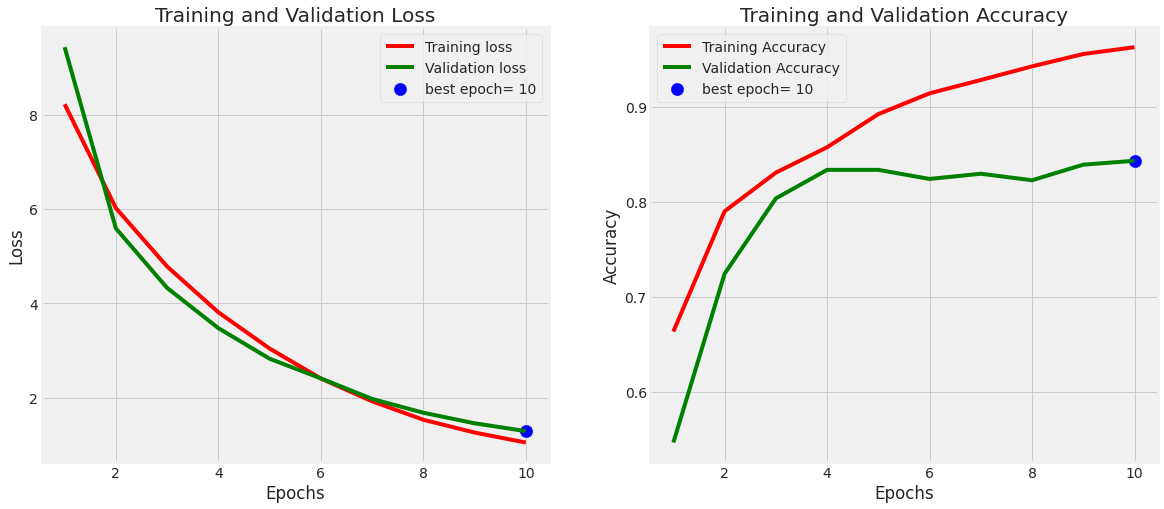

In [11]:
plot_training(history)

### Evaluate model

In [12]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

19/19 [==============================] - 74s 4s/step - loss: 1.2967 - accuracy: 0.8431
Train Loss:  0.8717820048332214
Train Accuracy:  0.9883919358253479
--------------------
Validation Loss:  1.2967157363891602
Validation Accuracy:  0.8431105017662048


In [15]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 25.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 8.4 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=065a776ae5e3cc17282fc965718e96d3ef91a684c5e1207e24c96783e5a78311
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
Successfully built ffmpy


In [16]:
import gradio as gr

In [35]:
def predict_image(img):
  img_4d=img.reshape(-1,224,224,3)
  prediction=model.predict(img_4d)[0]
  return {classes[i]: float(prediction[i]) for i in range(5)}

In [36]:
image = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=5)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:258: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/conda/lib/python3.7/site-packages/gradio/outputs.py:198: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://9b6702851cf8be8289.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9b6702851cf8be8289.gradio.live


In [14]:
model.export(file = Path("/kaggle/working/amazon_model1.pkl"))

AttributeError: 'Sequential' object has no attribute 'export'

# Submission

### Create test generator

In [ ]:
test_dir = '/kaggle/input/aptos2019-blindness-detection/test_images'
test_csv = '/kaggle/input/aptos2019-blindness-detection/test.csv'
test_df = pd.read_csv(test_csv)
test_df['id_code'] = test_df['id_code'] + ".png"
test_df['diagnosis'] = np.zeros(test_df.shape[0])
img_size = (224, 224)
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

def scalar(img):
    return img
    
tst_gen = ImageDataGenerator(preprocessing_function= scalar)
test_gen = tst_gen.flow_from_dataframe( test_df, x_col= 'id_code', y_col= 'diagnosis', directory= test_dir, target_size= img_size,
                                        color_mode= 'rgb', class_mode='raw', shuffle= False, batch_size= test_batch_size)

### Get Prediction

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
y_pred

In [ ]:
test_df['diagnosis'] = y_pred

In [ ]:
test_df

### Save the model

In [ ]:
model_name = 'EffecientNetB5'
subject = 'Blindness-Detection'
acc = valid_score[1] * 100
save_path = ''

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save Submission

In [ ]:
test_df.to_csv('Submission.csv')